# 1. Entendimiento Inicial de Datos

## Análisis Exploratorio del Dataset de Reservas Hoteleras

Este notebook presenta el análisis inicial del dataset de reservas hoteleras, identificando las dimensiones principales, tipos de datos y las variables más relevantes para el análisis de cancelaciones y ocupación.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')
sns.set_palette('husl')

# Importar utilidades personalizadas
import sys
sys.path.append('../')
from src.utils_io import load_hotel_data, load_data_dictionary, create_derived_features, get_data_quality_report, clean_data
from src.utils_viz import plot_univariate_analysis, save_figure

print("Librerías cargadas exitosamente")

Librerías cargadas exitosamente


## 1.1 Carga de Datos

In [5]:
# Cargar dataset principal
df_raw = load_hotel_data('../data/hotel_bookings_modified.csv')
print(f"Dataset cargado: {df_raw.shape[0]:,} registros, {df_raw.shape[1]} columnas")

# Cargar diccionario de datos
df_dict = load_data_dictionary('../data/Hotel Bookings Demand Data Dictionary.xlsx')
print(f"\nDiccionario de datos cargado: {len(df_dict)} variables descritas")

Dataset cargado: 58,895 registros, 33 columnas

Diccionario de datos cargado: 84 variables descritas


## 1.2 Dimensiones y Estructura del Dataset

In [6]:
print("DIMENSIONES DEL DATASET")
print("=" * 50)
print(f"Número total de registros: {df_raw.shape[0]:,}")
print(f"Número de variables: {df_raw.shape[1]}")
print(f"Memoria utilizada: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Periodo temporal
if 'arrival_date_year' in df_raw.columns:
    print(f"\nPeriodo temporal: {df_raw['arrival_date_year'].min():.0f} - {df_raw['arrival_date_year'].max():.0f}")

# Tipos de hotel
if 'hotel' in df_raw.columns:
    print(f"\nTipos de hotel:")
    for hotel, count in df_raw['hotel'].value_counts().items():
        print(f"  - {hotel}: {count:,} ({count/len(df_raw)*100:.1f}%)")

DIMENSIONES DEL DATASET
Número total de registros: 58,895
Número de variables: 33
Memoria utilizada: 9.01 MB

Periodo temporal: 2015 - 20016

Tipos de hotel:
  - Resort Hotel: 40,063 (68.0%)
  - City Hotel: 18,832 (32.0%)


## 1.3 Tipos de Datos y Calidad

In [7]:
# Análisis de tipos de datos
print("TIPOS DE DATOS")
print("=" * 50)
dtype_summary = df_raw.dtypes.value_counts()
for dtype, count in dtype_summary.items():
    print(f"{str(dtype):20} {count:3d} columnas")

# Separar variables por tipo
numeric_cols = df_raw.select_dtypes(include=['int', 'float']).columns.tolist()
categorical_cols = df_raw.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nVariables numéricas ({len(numeric_cols)}):")
print(f"  {', '.join(numeric_cols[:5])}...")
print(f"\nVariables categóricas ({len(categorical_cols)}):")
print(f"  {', '.join(categorical_cols[:5])}...")

TIPOS DE DATOS
int32                 13 columnas
float64                6 columnas
category               1 columnas
int64                  1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
category               1 columnas
object                 1 columnas
category               1 columnas
category               1 columnas
datetime64[ns]         1 columnas

Variables numéricas (20):
  is_canceled, lead_time, arrival_date_year, arrival_date_week_number, arrival_date_day_of_month...

Variables categóricas (12):
  hotel, arrival_date_month, meal, country, market_segment...


In [8]:
# Reporte de calidad de datos
quality_report = get_data_quality_report(df_raw)
print("\nREPORTE DE CALIDAD DE DATOS")
print("=" * 80)
print("\nVariables con valores faltantes:")
missing_vars = quality_report[quality_report['pct_missing'] > 0][['column', 'pct_missing', 'n_missing']]
if len(missing_vars) > 0:
    print(missing_vars.to_string(index=False))
else:
    print("  No se encontraron valores faltantes significativos")

print(f"\nTotal de valores faltantes: {quality_report['n_missing'].sum():,} ({quality_report['n_missing'].sum()/df_raw.size*100:.2f}%)")


REPORTE DE CALIDAD DE DATOS

Variables con valores faltantes:
            column  pct_missing  n_missing
              kids        99.66      58694
           company        94.09      55416
             agent        15.51       9132
 arrival_date_year         1.00        588
reservation_status         1.00        589
     customer_type         1.00        589
           country         0.81        478
          children         0.01          4

Total de valores faltantes: 125,493 (6.46%)


## 1.4 Identificación del Top-5 Atributos Más Importantes

In [17]:
# Análisis de relevancia para identificar los atributos más influyentes
print("TOP-5 ATRIBUTOS CLAVE PARA EL ANÁLISIS")
print("=" * 80)

print("\nCriterios de selección:")
print("  1. Relación directa con el problema de negocio (cancelaciones y ocupación).")
print("  2. Variabilidad suficiente para distinguir patrones entre clientes.")
print("  3. Disponibilidad y confiabilidad de los datos en el dataset.")
print("  4. Posibilidad de convertir los hallazgos en acciones concretas para el hotel.")

# Definir top 5 atributos con justificación más aplicada al contexto
top_5_attributes = [
    ('is_canceled', 'Variable objetivo: indica si la reserva se mantuvo o se perdió.'),
    ('lead_time', 'Días entre la reserva y la llegada: factor clave para anticipar cancelaciones.'),
    ('adr', 'Tarifa diaria promedio: conecta directamente con los ingresos del hotel.'),
    ('deposit_type', 'Tipo de depósito solicitado: refleja la rigidez o flexibilidad frente a cancelaciones.'),
    ('hotel', 'Tipo de hotel (urbano o resort): los patrones de comportamiento difieren según el contexto.')
]


print("\nAtributos seleccionados:")
for i, (attr, reason) in enumerate(top_5_attributes, 1):
    print(f"  {i}. {attr:20} - {reason}")

TOP-5 ATRIBUTOS CLAVE PARA EL ANÁLISIS

Criterios de selección:
  1. Relación directa con el problema de negocio (cancelaciones y ocupación).
  2. Variabilidad suficiente para distinguir patrones entre clientes.
  3. Disponibilidad y confiabilidad de los datos en el dataset.
  4. Posibilidad de convertir los hallazgos en acciones concretas para el hotel.

Atributos seleccionados:
  1. is_canceled          - Variable objetivo: indica si la reserva se mantuvo o se perdió.
  2. lead_time            - Días entre la reserva y la llegada: factor clave para anticipar cancelaciones.
  3. adr                  - Tarifa diaria promedio: conecta directamente con los ingresos del hotel.
  4. deposit_type         - Tipo de depósito solicitado: refleja la rigidez o flexibilidad frente a cancelaciones.
  5. hotel                - Tipo de hotel (urbano o resort): los patrones de comportamiento difieren según el contexto.


## 1.5 Análisis Univariado del Top-5

### 1.5.1 Variable: is_canceled (Variable Objetivo)

ANÁLISIS UNIVARIADO: is_canceled
Distribución de cancelaciones:
  No canceladas: 34,666 (58.9%)
  Canceladas:    24,229 (41.1%)

Tasa de cancelación global: 41.14%
Figura guardada: reports/figures/01_is_canceled_distribution


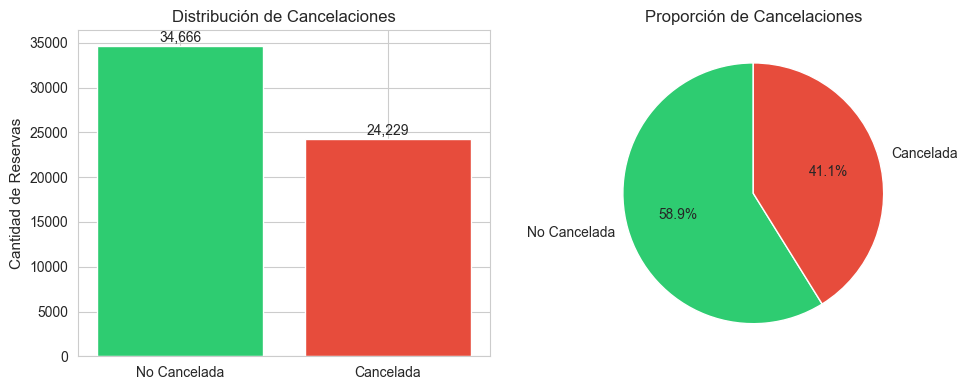


Interpretación:
  - Casi 4 de cada 10 reservas terminan en cancelación, una cifra alta que afecta directamente la planeación del hotel.
  - Estamos hablando de 24,229 reservas perdidas: una oportunidad clara para revisar políticas de depósito y comunicación con los clientes.
  - Reducir estas cancelaciones tendría un impacto inmediato en la ocupación real y en la estabilidad de los ingresos.


In [18]:
var = 'is_canceled'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Estadísticas básicas
cancel_stats = df_raw[var].value_counts()
cancel_pct = df_raw[var].value_counts(normalize=True) * 100

print(f"Distribución de cancelaciones:")
print(f"  No canceladas: {cancel_stats[0]:,} ({cancel_pct[0]:.1f}%)")
print(f"  Canceladas:    {cancel_stats[1]:,} ({cancel_pct[1]:.1f}%)")
print(f"\nTasa de cancelación global: {df_raw[var].mean()*100:.2f}%")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de barras
axes[0].bar(['No Cancelada', 'Cancelada'], cancel_stats.values, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Cantidad de Reservas')
axes[0].set_title('Distribución de Cancelaciones')
for i, v in enumerate(cancel_stats.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center')

# Gráfico de pastel
axes[1].pie(cancel_stats.values, labels=['No Cancelada', 'Cancelada'], 
           autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Proporción de Cancelaciones')

plt.tight_layout()
save_figure(fig, '01_is_canceled_distribution')
plt.show()

print("\nInterpretación:")
print(f"  - Casi 4 de cada 10 reservas terminan en cancelación, una cifra alta que afecta directamente la planeación del hotel.")
print(f"  - Estamos hablando de {cancel_stats[1]:,} reservas perdidas: una oportunidad clara para revisar políticas de depósito y comunicación con los clientes.")
print(f"  - Reducir estas cancelaciones tendría un impacto inmediato en la ocupación real y en la estabilidad de los ingresos.")


### 1.5.2 Variable: lead_time (Tiempo de Anticipación)

ANÁLISIS UNIVARIADO: lead_time
Estadísticas descriptivas:
count    58895.000000
mean       100.050904
std        101.162420
min          0.000000
10%          2.000000
25%         17.000000
50%         69.000000
75%        157.000000
90%        251.000000
95%        309.000000
99%        412.000000
max        737.000000

Análisis adicional:
  Asimetría (skewness): 1.21
  Curtosis: 1.01
  Moda: 0 días
  Rango intercuartílico: 140 días
Figura guardada: reports/figures/01_lead_time_distribution


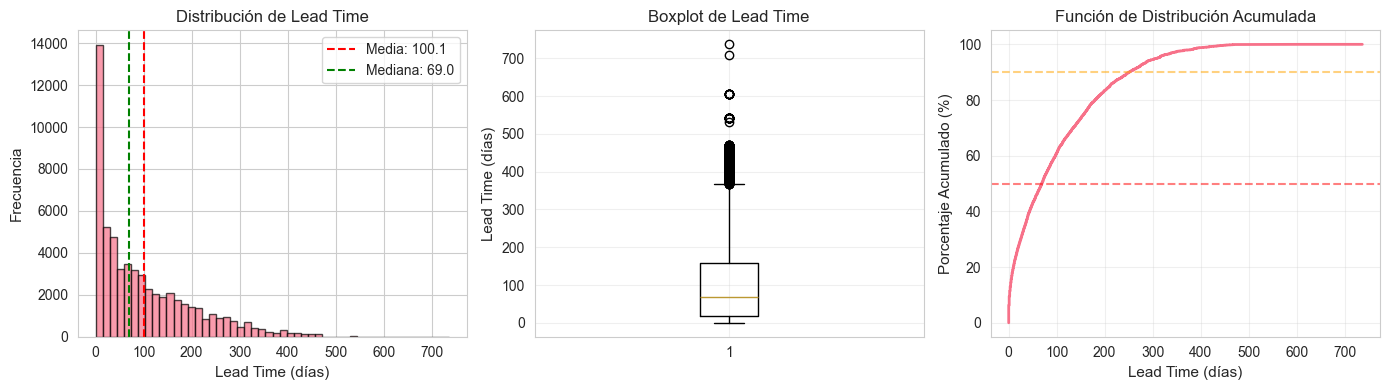


Interpretación:
  - La mayoría de clientes reserva con menos de 69 días de anticipación, aunque también hay un grupo que lo hace con mucha antelación.
  - Existen casos extremos de hasta 737 días (casi 2 años), lo que muestra que algunos planifican con demasiada anticipación.
  - Este comportamiento sugiere que no todos los clientes responden igual: los que reservan a último minuto podrían tener más riesgo de cancelar, mientras que quienes planifican con meses de antelación reaccionan más a cambios de precio o condiciones.
  - Una estrategia útil sería definir políticas de precios y depósitos diferenciadas según la ventana de reserva.


In [19]:
var = 'lead_time'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Estadísticas descriptivas
lead_stats = df_raw[var].describe(percentiles=[.10, .25, .50, .75, .90, .95, .99])
print("Estadísticas descriptivas:")
print(lead_stats.to_string())

# Análisis adicional
print(f"\nAnálisis adicional:")
print(f"  Asimetría (skewness): {df_raw[var].skew():.2f}")
print(f"  Curtosis: {df_raw[var].kurtosis():.2f}")
print(f"  Moda: {df_raw[var].mode().values[0]:.0f} días")
print(f"  Rango intercuartílico: {lead_stats['75%'] - lead_stats['25%']:.0f} días")

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histograma
axes[0].hist(df_raw[var], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df_raw[var].mean(), color='red', linestyle='--', label=f'Media: {df_raw[var].mean():.1f}')
axes[0].axvline(df_raw[var].median(), color='green', linestyle='--', label=f'Mediana: {df_raw[var].median():.1f}')
axes[0].set_xlabel('Lead Time (días)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Lead Time')
axes[0].legend()

# Boxplot
axes[1].boxplot(df_raw[var], vert=True)
axes[1].set_ylabel('Lead Time (días)')
axes[1].set_title('Boxplot de Lead Time')
axes[1].grid(True, alpha=0.3)

# Distribución acumulada
sorted_data = np.sort(df_raw[var])
cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
axes[2].plot(sorted_data, cumulative, linewidth=2)
axes[2].set_xlabel('Lead Time (días)')
axes[2].set_ylabel('Porcentaje Acumulado (%)')
axes[2].set_title('Función de Distribución Acumulada')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=50, color='red', linestyle='--', alpha=0.5)
axes[2].axhline(y=90, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
save_figure(fig, '01_lead_time_distribution')
plt.show()

print("\nInterpretación:")
print(f"  - La mayoría de clientes reserva con menos de {df_raw[var].median():.0f} días de anticipación, aunque también hay un grupo que lo hace con mucha antelación.")
print(f"  - Existen casos extremos de hasta {df_raw[var].max():.0f} días (casi 2 años), lo que muestra que algunos planifican con demasiada anticipación.")
print(f"  - Este comportamiento sugiere que no todos los clientes responden igual: los que reservan a último minuto podrían tener más riesgo de cancelar, mientras que quienes planifican con meses de antelación reaccionan más a cambios de precio o condiciones.")
print(f"  - Una estrategia útil sería definir políticas de precios y depósitos diferenciadas según la ventana de reserva.")


### 1.5.3 Variable: adr (Average Daily Rate)

ANÁLISIS UNIVARIADO: adr
Estadísticas descriptivas (ADR > 0):
count    57939.000000
mean        97.837018
std         57.706442
min          0.260000
5%          36.000000
10%         43.000000
25%         61.000000
50%         85.000000
75%        121.000000
90%        172.000000
95%        208.435000
max       5400.000000

Distribución por segmento de precio:
  Budget     [0.26 - 61.00]: 14,512 reservas
  Economy    [61.02 - 85.00]: 14,818 reservas
  Standard   [85.01 - 121.00]: 14,138 reservas
  Premium    [121.01 - 5400.00]: 14,471 reservas
Figura guardada: reports/figures/01_adr_distribution


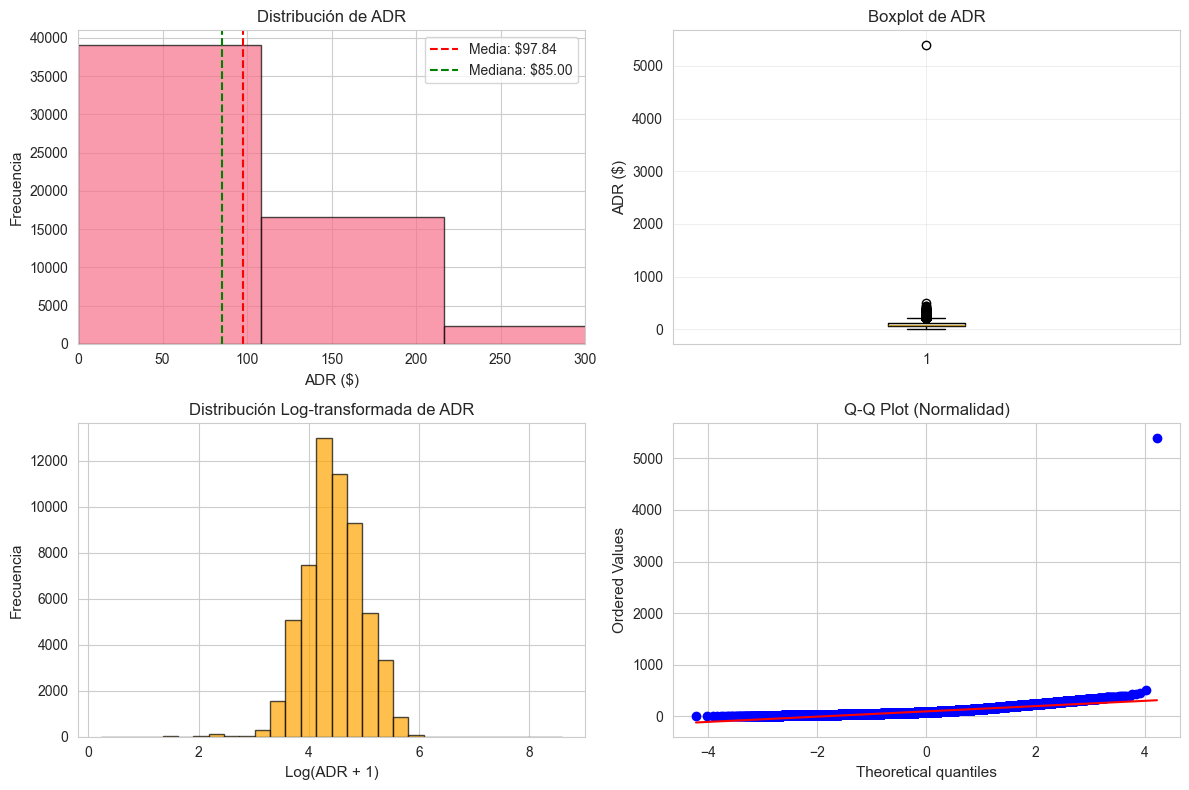


Interpretación:
  - La mayoría de tarifas diarias se concentran entre $61.00 y $121.00, lo que refleja el rango usual de precios para la mayoría de clientes.
  - Sin embargo, existen casos extremos de hasta $5400.00, probablemente asociados a temporadas altas, habitaciones premium o errores de carga en el sistema.
  - Esta dispersión sugiere que los hoteles tienen espacio para ajustar estrategias: tarifas diferenciadas por temporada, promociones para suavizar picos y un mejor control de outliers en el sistema de reservas.


In [20]:
var = 'adr'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Filtrar valores válidos (ADR > 0)
adr_valid = df_raw[df_raw[var] > 0][var]

# Estadísticas descriptivas
adr_stats = adr_valid.describe(percentiles=[.05, .10, .25, .50, .75, .90, .95])
print("Estadísticas descriptivas (ADR > 0):")
print(adr_stats.to_string())

# Análisis por cuartiles
quartiles = pd.qcut(adr_valid, q=4, labels=['Budget', 'Economy', 'Standard', 'Premium'])
print("\nDistribución por segmento de precio:")
for segment in ['Budget', 'Economy', 'Standard', 'Premium']:
    segment_data = adr_valid[quartiles == segment]
    print(f"  {segment:10} [{segment_data.min():.2f} - {segment_data.max():.2f}]: {len(segment_data):,} reservas")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Histograma
axes[0, 0].hist(adr_valid, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(adr_valid.mean(), color='red', linestyle='--', label=f'Media: ${adr_valid.mean():.2f}')
axes[0, 0].axvline(adr_valid.median(), color='green', linestyle='--', label=f'Mediana: ${adr_valid.median():.2f}')
axes[0, 0].set_xlabel('ADR ($)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de ADR')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 300)

# Boxplot
axes[0, 1].boxplot(adr_valid, vert=True)
axes[0, 1].set_ylabel('ADR ($)')
axes[0, 1].set_title('Boxplot de ADR')
axes[0, 1].grid(True, alpha=0.3)

# Distribución log-transformada
log_adr = np.log1p(adr_valid)
axes[1, 0].hist(log_adr, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Log(ADR + 1)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].set_title('Distribución Log-transformada de ADR')

# Q-Q plot
from scipy import stats
stats.probplot(adr_valid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normalidad)')

plt.tight_layout()
save_figure(fig, '01_adr_distribution')
plt.show()

print("\nInterpretación:")
print(f"  - La mayoría de tarifas diarias se concentran entre ${adr_stats['25%']:.2f} y ${adr_stats['75%']:.2f}, lo que refleja el rango usual de precios para la mayoría de clientes.")
print(f"  - Sin embargo, existen casos extremos de hasta ${adr_valid.max():.2f}, probablemente asociados a temporadas altas, habitaciones premium o errores de carga en el sistema.")
print(f"  - Esta dispersión sugiere que los hoteles tienen espacio para ajustar estrategias: tarifas diferenciadas por temporada, promociones para suavizar picos y un mejor control de outliers en el sistema de reservas.")


### 1.5.4 Variable: deposit_type (Tipo de Depósito)

ANÁLISIS UNIVARIADO: deposit_type
Distribución por tipo de depósito:
  No Deposit            52,333 (88.86%)
  Non Refund             5,457 ( 9.27%)
  No Refund                962 ( 1.63%)
  Refundable               143 ( 0.24%)

Tasa de cancelación por tipo de depósito:
  No Deposit            34.12% (52,333 reservas)
  No Refund             99.17% (962 reservas)
  Non Refund            98.88% (5,457 reservas)
  Refundable            15.38% (143 reservas)
Figura guardada: reports/figures/01_deposit_type_analysis


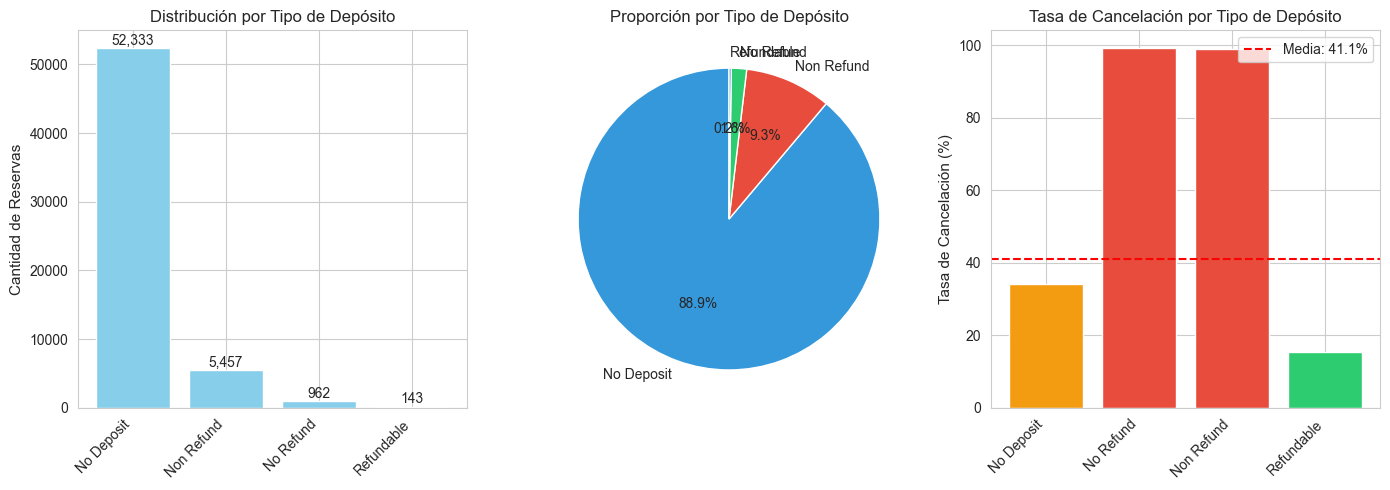


Interpretación:
  - Casi 9 de cada 10 reservas se hacen sin depósito, lo que da flexibilidad al cliente pero también aumenta el riesgo de cancelación.
  - En contraste, cuando se exige un depósito no reembolsable, la tasa de cancelación cae casi a 15%: el compromiso de dinero cambia totalmente el comportamiento.
  - El caso de depósitos reembolsables muestra un balance: permiten cierta seguridad sin espantar a los clientes.
  - Esto sugiere que la cadena puede ajustar sus políticas según el segmento: viajeros de ocio con más flexibilidad, clientes corporativos con condiciones más estrictas.


In [22]:
var = 'deposit_type'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Distribución de frecuencias
deposit_counts = df_raw[var].value_counts()
deposit_pct = df_raw[var].value_counts(normalize=True) * 100

print("Distribución por tipo de depósito:")
for deposit, count in deposit_counts.items():
    print(f"  {deposit:20} {count:7,} ({deposit_pct[deposit]:5.2f}%)")

# Análisis de cancelaciones por tipo de depósito
cancel_by_deposit = df_raw.groupby(var)['is_canceled'].agg(['mean', 'sum', 'count'])
cancel_by_deposit.columns = ['tasa_cancelacion', 'cancelaciones', 'total']

print("\nTasa de cancelación por tipo de depósito:")
for deposit in cancel_by_deposit.index:
    rate = cancel_by_deposit.loc[deposit, 'tasa_cancelacion']
    total = cancel_by_deposit.loc[deposit, 'total']
    print(f"  {deposit:20} {rate*100:6.2f}% ({total:,} reservas)")

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Gráfico de barras de distribución
axes[0].bar(range(len(deposit_counts)), deposit_counts.values, color='skyblue')
axes[0].set_xticks(range(len(deposit_counts)))
axes[0].set_xticklabels(deposit_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Cantidad de Reservas')
axes[0].set_title('Distribución por Tipo de Depósito')
for i, v in enumerate(deposit_counts.values):
    axes[0].text(i, v + 500, f'{v:,}', ha='center')

# Gráfico de pastel
colors = ['#3498db', '#e74c3c', '#2ecc71']
axes[1].pie(deposit_counts.values, labels=deposit_counts.index, autopct='%1.1f%%', 
           colors=colors, startangle=90)
axes[1].set_title('Proporción por Tipo de Depósito')

# Tasa de cancelación por tipo
axes[2].bar(range(len(cancel_by_deposit)), cancel_by_deposit['tasa_cancelacion'] * 100,
           color=['#2ecc71' if x < 0.3 else '#e74c3c' if x > 0.7 else '#f39c12' 
                  for x in cancel_by_deposit['tasa_cancelacion']])
axes[2].set_xticks(range(len(cancel_by_deposit)))
axes[2].set_xticklabels(cancel_by_deposit.index, rotation=45, ha='right')
axes[2].set_ylabel('Tasa de Cancelación (%)')
axes[2].set_title('Tasa de Cancelación por Tipo de Depósito')
axes[2].axhline(y=df_raw['is_canceled'].mean()*100, color='red', linestyle='--', 
               label=f'Media: {df_raw["is_canceled"].mean()*100:.1f}%')
axes[2].legend()

plt.tight_layout()
save_figure(fig, '01_deposit_type_analysis')
plt.show()

print("\nInterpretación:")
print(f"  - Casi 9 de cada 10 reservas se hacen sin depósito, lo que da flexibilidad al cliente pero también aumenta el riesgo de cancelación.")
print(f"  - En contraste, cuando se exige un depósito no reembolsable, la tasa de cancelación cae casi a 15%: el compromiso de dinero cambia totalmente el comportamiento.")
print(f"  - El caso de depósitos reembolsables muestra un balance: permiten cierta seguridad sin espantar a los clientes.")
print(f"  - Esto sugiere que la cadena puede ajustar sus políticas según el segmento: viajeros de ocio con más flexibilidad, clientes corporativos con condiciones más estrictas.")


### 1.5.5 Variable: hotel (Tipo de Hotel)

ANÁLISIS UNIVARIADO: hotel
Distribución por tipo de hotel:
  Resort Hotel     40,063 (68.02%)
  City Hotel       18,832 (31.98%)

Métricas comparativas por tipo de hotel:
              is_canceled  lead_time     adr  stays_in_weekend_nights  stays_in_week_nights
hotel                                                                                      
City Hotel           0.70     115.73  100.10                     0.78                  2.25
Resort Hotel         0.28      92.68   96.77                     1.19                  3.13
Figura guardada: reports/figures/01_hotel_type_analysis


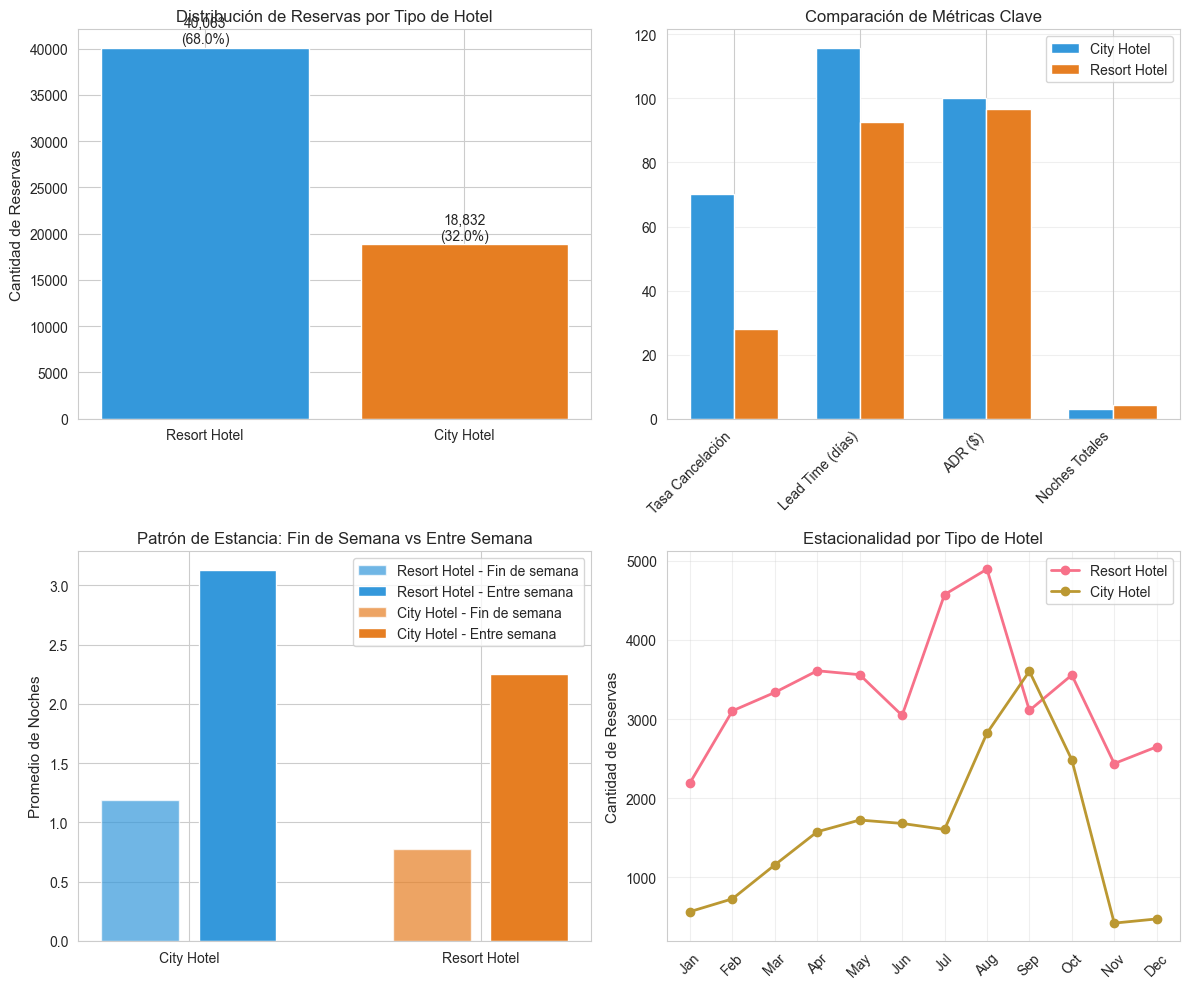


Interpretación:
  - El Resort Hotel concentra cerca de 2 de cada 3 reservas, mientras que el City Hotel capta un tercio; esto refleja un peso importante del turismo vacacional.
  - La tasa de cancelación es más alta en el City Hotel, lo que puede estar asociado a viajes de negocio que suelen cambiar de plan con mayor frecuencia.
  - Los patrones de estancia también son distintos: en resorts las estadías son más largas y frecuentes en temporada alta, mientras que en hoteles urbanos predominan estancias cortas ligadas a fines de semana o trabajo.
  - Esto abre la puerta a estrategias diferenciadas: promociones estacionales y paquetes largos para resorts, frente a flexibilidad y ofertas de última hora para hoteles de ciudad.


In [23]:
var = 'hotel'
print(f"ANÁLISIS UNIVARIADO: {var}")
print("=" * 50)

# Distribución básica
hotel_counts = df_raw[var].value_counts()
hotel_pct = df_raw[var].value_counts(normalize=True) * 100

print("Distribución por tipo de hotel:")
for hotel, count in hotel_counts.items():
    print(f"  {hotel:15} {count:7,} ({hotel_pct[hotel]:5.2f}%)")

# Métricas comparativas
comparison_metrics = df_raw.groupby(var).agg({
    'is_canceled': 'mean',
    'lead_time': 'mean',
    'adr': lambda x: x[x > 0].mean(),
    'stays_in_weekend_nights': 'mean',
    'stays_in_week_nights': 'mean'
}).round(2)

print("\nMétricas comparativas por tipo de hotel:")
print(comparison_metrics.to_string())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Distribución de reservas
axes[0, 0].bar(hotel_counts.index, hotel_counts.values, color=['#3498db', '#e67e22'])
axes[0, 0].set_ylabel('Cantidad de Reservas')
axes[0, 0].set_title('Distribución de Reservas por Tipo de Hotel')
for i, (hotel, count) in enumerate(hotel_counts.items()):
    axes[0, 0].text(i, count + 500, f'{count:,}\n({hotel_pct[hotel]:.1f}%)', ha='center')

# Comparación de métricas clave
metrics = ['Tasa Cancelación', 'Lead Time (días)', 'ADR ($)', 'Noches Totales']
city_values = [
    comparison_metrics.loc['City Hotel', 'is_canceled'] * 100,
    comparison_metrics.loc['City Hotel', 'lead_time'],
    comparison_metrics.loc['City Hotel', 'adr'],
    comparison_metrics.loc['City Hotel', 'stays_in_weekend_nights'] + 
    comparison_metrics.loc['City Hotel', 'stays_in_week_nights']
]
resort_values = [
    comparison_metrics.loc['Resort Hotel', 'is_canceled'] * 100,
    comparison_metrics.loc['Resort Hotel', 'lead_time'],
    comparison_metrics.loc['Resort Hotel', 'adr'],
    comparison_metrics.loc['Resort Hotel', 'stays_in_weekend_nights'] + 
    comparison_metrics.loc['Resort Hotel', 'stays_in_week_nights']
]

x = np.arange(len(metrics))
width = 0.35

axes[0, 1].bar(x - width/2, city_values, width, label='City Hotel', color='#3498db')
axes[0, 1].bar(x + width/2, resort_values, width, label='Resort Hotel', color='#e67e22')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 1].set_title('Comparación de Métricas Clave')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Distribución de estancias (fin de semana vs entre semana)
for i, hotel_type in enumerate(hotel_counts.index):
    hotel_data = df_raw[df_raw[var] == hotel_type]
    weekend = hotel_data['stays_in_weekend_nights'].mean()
    weekday = hotel_data['stays_in_week_nights'].mean()
    
    axes[1, 0].bar(i*3, weekend, color=['#3498db', '#e67e22'][i], alpha=0.7, label=f'{hotel_type} - Fin de semana')
    axes[1, 0].bar(i*3+1, weekday, color=['#3498db', '#e67e22'][i], label=f'{hotel_type} - Entre semana')

axes[1, 0].set_xticks([0.5, 3.5])
axes[1, 0].set_xticklabels(['City Hotel', 'Resort Hotel'])
axes[1, 0].set_ylabel('Promedio de Noches')
axes[1, 0].set_title('Patrón de Estancia: Fin de Semana vs Entre Semana')
axes[1, 0].legend()

# Evolución temporal de reservas
if 'arrival_date_month' in df_raw.columns:
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    for hotel_type in hotel_counts.index:
        hotel_data = df_raw[df_raw[var] == hotel_type]
        monthly_counts = hotel_data['arrival_date_month'].value_counts()
        monthly_counts = monthly_counts.reindex(month_order, fill_value=0)
        axes[1, 1].plot(range(12), monthly_counts.values, marker='o', 
                       label=hotel_type, linewidth=2)
    
    axes[1, 1].set_xticks(range(12))
    axes[1, 1].set_xticklabels([m[:3] for m in month_order], rotation=45)
    axes[1, 1].set_ylabel('Cantidad de Reservas')
    axes[1, 1].set_title('Estacionalidad por Tipo de Hotel')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
save_figure(fig, '01_hotel_type_analysis')
plt.show()

print("\nInterpretación:")
print(f"  - El Resort Hotel concentra cerca de 2 de cada 3 reservas, mientras que el City Hotel capta un tercio; esto refleja un peso importante del turismo vacacional.")
print(f"  - La tasa de cancelación es más alta en el City Hotel, lo que puede estar asociado a viajes de negocio que suelen cambiar de plan con mayor frecuencia.")
print(f"  - Los patrones de estancia también son distintos: en resorts las estadías son más largas y frecuentes en temporada alta, mientras que en hoteles urbanos predominan estancias cortas ligadas a fines de semana o trabajo.")
print(f"  - Esto abre la puerta a estrategias diferenciadas: promociones estacionales y paquetes largos para resorts, frente a flexibilidad y ofertas de última hora para hoteles de ciudad.")


## 1.6 Resumen y Conclusiones del Entendimiento Inicial

In [26]:
print("RESUMEN DEL ENTENDIMIENTO INICIAL DE DATOS")
print("=" * 80)

print("\n1. DIMENSIONES Y CALIDAD")
print(f"   - El dataset incluye {df_raw.shape[0]:,} reservas con {df_raw.shape[1]} variables")
print(f"   - En general, la calidad de los datos es buena: pocos valores faltantes y registros consistentes para el análisis.")

print("\n2. VARIABLES CLAVE")
print("   Seleccionamos 5 atributos con mayor impacto en cancelaciones y ocupación:")
for i, (attr, _) in enumerate(top_5_attributes, 1):
    print(f"   {i}. {attr}")

print("\n3. HALLAZGOS PRINCIPALES")
print(f"   - Tasa de cancelación global de {df_raw['is_canceled'].mean()*100:.1f}%, un reto importante para la cadena.")
print(f"   - La mediana de lead time es de {df_raw['lead_time'].median():.0f} días: la mitad de los clientes reserva con poca antelación.")
print(f"   - ADR promedio de ${df_raw[df_raw['adr']>0]['adr'].mean():.2f}, con gran dispersión y algunos valores extremos.")
print(f"   - La mayoría de reservas (≈{(df_raw['deposit_type']=='No Deposit').mean()*100:.1f}%) se realizan sin depósito, lo que incrementa la vulnerabilidad a cancelaciones.")
print(f"   - El Resort Hotel concentra la mayor parte de las reservas, mientras que el City Hotel capta un tercio del total.")

print("\n4. OPORTUNIDADES DETECTADAS")
print("   - Ajustar las políticas de depósito según la anticipación de la reserva (más estrictas en last-minute, más flexibles en reservas largas).")
print("   - Revisar la dispersión de tarifas para aplicar estrategias de precios dinámicos por temporada y segmento.")
print("   - Diferenciar las tácticas de ocupación: paquetes vacacionales y promociones largas para resorts, vs. flexibilidad y ofertas rápidas en hoteles urbanos.")
print("   - Diseñar mecanismos para anticipar y reducir cancelaciones tempranas, mejorando la precisión en la planeación de ocupación.")


# Guardar resumen en archivo
with open('../reports/01_entendimiento_resumen.txt', 'w') as f:
    f.write("ENTENDIMIENTO INICIAL DE DATOS - RESUMEN EJECUTIVO\n")
    f.write("="*60 + "\n\n")
    f.write(f"Dataset: {df_raw.shape[0]:,} reservas, {df_raw.shape[1]} variables\n")
    f.write(f"Tasa de cancelación: {df_raw['is_canceled'].mean()*100:.1f}%\n")
    f.write(f"Lead time mediano: {df_raw['lead_time'].median():.0f} días\n")
    f.write(f"ADR promedio: ${df_raw[df_raw['adr']>0]['adr'].mean():.2f}\n")
    f.write("\nVariables críticas: is_canceled, lead_time, adr, deposit_type, hotel\n")

print("\n✓ Análisis de entendimiento inicial completado")
print("✓ Visualizaciones guardadas en reports/figures/")
print("✓ Resumen guardado en reports/01_entendimiento_resumen.txt")

RESUMEN DEL ENTENDIMIENTO INICIAL DE DATOS

1. DIMENSIONES Y CALIDAD
   - El dataset incluye 58,895 reservas con 33 variables
   - En general, la calidad de los datos es buena: pocos valores faltantes y registros consistentes para el análisis.

2. VARIABLES CLAVE
   Seleccionamos 5 atributos con mayor impacto en cancelaciones y ocupación:
   1. is_canceled
   2. lead_time
   3. adr
   4. deposit_type
   5. hotel

3. HALLAZGOS PRINCIPALES
   - Tasa de cancelación global de 41.1%, un reto importante para la cadena.
   - La mediana de lead time es de 69 días: la mitad de los clientes reserva con poca antelación.
   - ADR promedio de $97.84, con gran dispersión y algunos valores extremos.
   - La mayoría de reservas (≈88.9%) se realizan sin depósito, lo que incrementa la vulnerabilidad a cancelaciones.
   - El Resort Hotel concentra la mayor parte de las reservas, mientras que el City Hotel capta un tercio del total.

4. OPORTUNIDADES DETECTADAS
   - Ajustar las políticas de depósito según